![Callysto.ca Banner](https://github.com/callysto/curriculum-notebooks/blob/master/callysto-notebook-banner-top.jpg?raw=true)

<a href="https://hub.callysto.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fcallysto%2Fcahiers-de-programmes&branch=master&subPath=EtudesSociales/la-times-extension.ipynb&depth=1" target="_parent"><img src="https://raw.githubusercontent.com/callysto/cahiers-de-programmes/master/bouton-callysto.svg?sanitize=true" width="123" height="24" alt="Open in Callysto"/></a>

In [1]:
# Import Python tools
from IPython.display import HTML
from IPython import display 
from ipywidgets import widgets
from ipywidgets import interactive

# import calculate
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot
import chart_studio.plotly as py
import plotly.graph_objs as go


init_notebook_mode(connected=True)         
import warnings

warnings.filterwarnings("ignore")

# Introduction
Ce cahier est une extension et, à certains égards, une version plus transparente (ne serait-ce qu'en plaçant les ajustements de l'inflation au centre) de l'article de Los Angeles disponible le 17 mars 2017 ["Les salaires augmentent dans les fermes californiennes. veux le travail"](http://www.latimes.com/projects/la-fi-farms-immigration/). Dans ce cahier, nous l’avons modifié afin que vous puissiez appliquer vous-même les ajustements en fonction de l’inflation et comparer plusieurs salaires d’État. De plus, nous avons ajouté les industries "Traitement des données, hébergement et services connexes" à l'ensemble de données pour comparer la croissance des salaires entre les deux.

In [2]:
"""
Adjusts dollar figures for inflation using the Consumer Price Index.

Note: This function and the cpi values are taken directly from the LA times article. The
one change we have made is that our inflation adjustmetns are not just to 2015 (although, 
that might be the only year you're interested in for inflation adjustments) 
"""
cpi = {
  "1990": 130.658,
  "1991": 136.167,
  "1992": 140.308,
  "1993": 144.475,
  "1994": 148.225,
  "1995": 152.383,
  "1996": 156.858,
  "1997": 160.525,
  "1998": 163.008,
  "1999": 166.583,
  "2000": 172.192,
  "2001": 177.042,
  "2002": 179.867,
  "2003": 184.0,
  "2004": 188.908,
  "2005": 195.267,
  "2006": 201.558,
  "2007": 207.344,
  "2008": 215.254,
  "2009": 214.565,
  "2010": 218.076,
  "2011": 224.93,
  "2012": 229.6,
  "2013": 232.962,
  "2014": 236.712,
  "2015": 237.0
}

def convert_to_year(value, year, to_year):
    return (value * cpi[str(to_year)]) / cpi[str(year)] 

In [3]:
# Read in state-level data
# Because the data set takes a while to create, this is a version that we're hosting on our cloud. 
# This is slightly modified to remove the inflation correction in pre processing, as we're going to 
# show it directly here. 
state_df = pd.read_csv("https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/callysto-open-data/transformed_state.csv", dtype={"area_fips": "str"})
state_df.head()

,year,area_fips,area_title,industry_group,annual_avg_emplvl,total_annual_wages_2015,avg_annual_pay_2015
0,1990,01000,Alabama -- Statewide,crops,4206,54467330,12949.912030
1,1990,01000,Alabama -- Statewide,data,3606,66339110,18396.869107
2,1990,01000,Alabama -- Statewide,total,1600920,32767666541,20468.022475
3,1990,02000,Alaska -- Statewide,crops,124,1710636,13795.451613
4,1990,02000,Alaska -- Statewide,data,214,4770228,22290.785047


Le tableau ci-dessus affiche les premières entrées de la table de données agrégée et filtrée de l'analyse des temps LA. Nous avons également ajouté un groupe sectoriel "données" pour des analyses futures, mais l'objectif de ce cahier concerne uniquement les cultures. Ce qui est le plus important à voir ici, c'est que cette table de données contient des données provenant de plus d'états que la Californie. Cela signifie que nous pouvons maintenant comparer plusieurs états entre eux.

## Reproduction des résultats du LA Times

Notre première tâche est de reproduire l'analyse du LA Times ici. Avant de commencer à comparer différents états / appliquer différents calculs. Premièrement, nous copions et collons sans vergogne l’analyse du LA Times à partir du bloc-notes disponible sur leur dépôt de hub git.

In [4]:
# Filter that down to just California crop workers
# Here 06 is the beginning code of California. 
ca_state_df = state_df[state_df.area_fips.str.startswith("06")]
# Now we're just filtering down to only crops, and we're indexing it by year.
# an index can be thought of as the "row number" of the data table 
ca_state_crops = ca_state_df[ca_state_df.industry_group == 'crops'].set_index("year")


Tout d'abord, voir la rémunération annuelle moyenne des travailleurs de la Californie dans la cellule ci-dessous

In [5]:
ca_state_crops.at[2015, "avg_annual_pay_2015"]

29631.585333450963

L'étape suivante consiste à comparer cette valeur à la moyenne des travailleurs agricoles rémunérés en 1990

In [6]:
ca_state_crops.at[1990, "avg_annual_pay_2015"]

12471.487764018

Bien que cela semble être une amélioration significative, nous devons nous rappeler que les dollars de 1990 valent plus que nos dollars de 2015 gonflés.

---
### Essaye le

1. En utilisant les cellules ci-dessus, quelles pièces devriez-vous modifier pour voir les salaires en Californie dans une autre année? Essaye le.

---

Pour faire une comparaison plus juste, nous devons d'abord ajuster manuellement la valeur ci-dessus pour l'inflation. Nous notons que dans l’article du LA Times, l’ajustement de l’inflation a été effectué en coulisse. Avec aucune intention d'induire en erreur dans leur analyse, c'était pour la commodité de leur présentation des données. Les cellules ci-dessous ajustent ces valeurs pour la comparaison.

In [7]:
wage_1990 = ca_state_crops.at[1990, "avg_annual_pay_2015"]
wage_2015 = ca_state_crops.at[2015, "avg_annual_pay_2015"]

adjusted_wage_1990 = convert_to_year(value=wage_1990, year=1990, to_year=2015)

print("1990 Wage = $", adjusted_wage_1990, "\n2015 Wage = $", wage_2015)



1990 Wage = $ 22621.979519602828 
2015 Wage = $ 29631.585333450963


Là où nous voyons maintenant que même après ajustement pour tenir compte de l'inflation, les agriculteurs californiens ont vu une augmentation de salaire depuis 1990.

---
### Essaye le
 - Utilisez les cellules ci-dessus pour comparer différentes années aux salaires de 2015. Quelles valeurs devrez-vous changer pour ajuster l’inflation et obtenir des salaires corrects?
 
 ---

L'étape suivante consiste à reproduire la variation en pourcentage des salaires (ajustée en fonction de l'inflation) de 2010 à 2015 et à la comparer aux augmentations de salaires dans l'ensemble de l'État. Nous pouvons faire cela comme le LA Times en utilisant leur module de calcul ci-dessous, d'où vient la fonction `percent_change`.

In [8]:
wage_increase_crop = ca_state_crops.at[2015, "avg_annual_pay_2015"] / convert_to_year(ca_state_crops.at[2010, "avg_annual_pay_2015"], 2010,2015) * 100 - 100
print(f"Crop percent change = {round(wage_increase_crop,2)}%")

Crop percent change = 13.29%


In [9]:
ca_state_overall = ca_state_df[ca_state_df.industry_group == 'total'].set_index("year")

state_wage_increase = ca_state_overall.at[2015, "avg_annual_pay_2015"] / convert_to_year(ca_state_overall.at[2010, "avg_annual_pay_2015"], 2010,2015) * 100 - 100
print(f"State percent change = {round(state_wage_increase, 2)}%")

State percent change = 6.54%


Où cela a reproduit l'analyse du LA Times sur cette section

---
### Essaye le
- Quel a été le pourcentage de variation des salaires ajustés en fonction de l’inflation entre 1990 et 2015? Qu'en est-il de la non-inflation ajustée?

---


On voit alors que les salaires des ouvriers agricoles ont augmenté (légèrement) plus de deux fois le taux de salaire en Californie dans le même laps de temps

In [10]:
print(wage_increase_crop/state_wage_increase)

2.030279716550187


## Reproduire le graphique

Nous sommes maintenant en mesure de reproduire le graphique de l'article du LA Times, comme indiqué ci-dessous. La première ligne de code ci-dessous ajoute une autre colonne à notre tableau de données des salaires ajustés en fonction de l’inflation avant que nous ne la représentions.

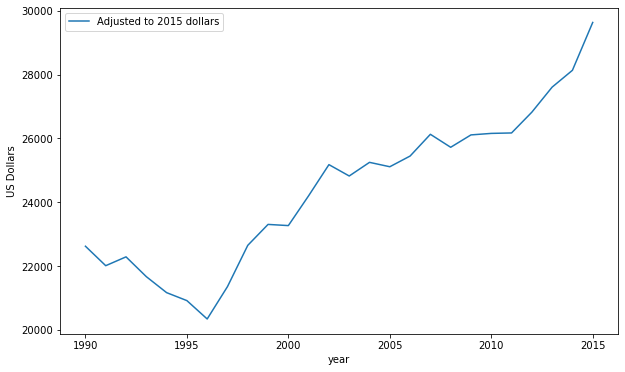

In [11]:
# Reproduce the graph
# First we create an inflation adjusted column.
# all lambda does for our purposes a way to address a function to pass
# row values to our function.  Row.name is the year as that's what we reindexed
# our data frame to earlier .
ca_state_crops["inflation_adj"] = ca_state_crops.apply(lambda row: 
                                                       convert_to_year(row.avg_annual_pay_2015, 
                                                                       row.name, 
                                                                       2015),
                                                       axis=1)

ca_state_crops.reset_index().plot(kind='line',
                                  x='year', 
                                  y=['inflation_adj'], 
                                  figsize=(10, 6),
                                  )
plt.legend(["Adjusted to 2015 dollars"])
plt.ylabel("US Dollars")
plt.show()

Où cela a réduit le graphique de l'article de LA Time, même si c'est peut-être moins esthétique.

---
### Essaye le

- Essayez d’ajouter la courbe non corrigée de l’inflation au graphique ci-dessus. Cela peut se faire en deux étapes
    1. Recherchez la ligne suivante dans le code ci-dessus
    ```python
    y = ['inflation_adj']
    ```
    et le changer pour
    ```python
    y = ['inflation_adj', avg_annual_pay_2015]
    ```
    2. Recherchez la ligne suivante dans le code ci-dessus
    ```python
       plt.legend(["Adjusted to 2015 dollars"])
    ```
    et le changer pour
    ```python
       plt.legend(["Adjusted to 2015 dollars", "your label here"])
    ```

---

Mais maintenant, cela pourrait devenir plus intéressant si nous commençons à comparer directement les salaires des différentes cultures. À partir de là, nous divergons maintenant de l'analyse du LA Times. Les informations de tous les états peuvent être affichées en utilisant le widget ci-dessous en ajustant les menus déroulants.

In [12]:
def make_df(state, kind):
    out_df = state_df[state_df.area_title.str.match(state)]
    out_df = out_df[out_df.industry_group == str(kind)].set_index("year")
    
    out_df["inflation_adj"] = out_df.apply(lambda row: 
                                                convert_to_year(row.avg_annual_pay_2015, 
                                                row.name, 
                                                2015),
                                                axis=1)
    
    return out_df

def state_comparison(state1, state2, kind, Show_actual = True):
    # Make a temporary frame for the state and reset index so
    # years are their own column
    state1_df = make_df(state1,kind)
    state1_df = state1_df.reset_index()
    if state2:
        state2_df = make_df(state2,kind)
        state2_df = state2_df.reset_index()
    fig = plt.figure(figsize=(12, 8))
   
    plt.plot(state1_df['year'], state1_df['inflation_adj'])
    
    difference1 = state1_df.at[25, "inflation_adj"]-state1_df.at[0, "inflation_adj"]
        
    plt.legend([ "Adjusted to 2015 dollars", "No Adjustment for Inflation"])
    plt.ylabel("US Dollars", size =16)
    plt.xlabel("Year", size=16)
    # Should we want to look at another state, we plot that too and
    # adjust the trace legends
    
    if state2:
        plt.plot(state2_df['year'], state2_df['inflation_adj'])

    else:
         plt.legend(["Adjusted to 2015 dollars","No Adjustment for Inflation"])
            
    if Show_actual:
        plt.plot(state1_df['year'], state1_df['avg_annual_pay_2015'])
        plt.legend(["Adjusted to 2015 dollars","No Adjustment for Inflation"])
        if state2:
            plt.plot(state2_df['year'], state2_df['avg_annual_pay_2015'])
            
    
    if state2:
        difference2 = state2_df.at[25, "inflation_adj"]-state2_df.at[0, "inflation_adj"]
        plt.legend([
            ' '.join([state1.rstrip(" Statewide"), "Adjusted to 2015 dollars"]),
            ' '.join([state2.rstrip(" Statewide"), "Adjusted to 2015 dollars"]),
            ' '.join([state1.rstrip(" Statewide"),"No Adjustment for Inflation"]),
            ' '.join([state2.rstrip(" Statewide"),"No Adjustment for Inflation"])
          
        ])
        
        plt.title(" ".join([state1.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference1,2)), '\n',
                            state2.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference2,2))]))
    else:
         plt.title(" ".join([state1.rstrip(" Statewide"),
                            "Change in pay (2015 dollars) = $",
                            str(round(difference1,2))]))
        
                            
    plt.show()
    
    
choices = list(state_df["area_title"].unique())[0:-1]
choices.remove('District of Columbia')
choices2 = [None] + choices

En utilisant le widget ci-dessus, vous pouvez comparer les payeurs entre les états et voir les échelles de salaire non modifiées en cliquant sur "Afficher _". Vous pouvez également ajuster l'inflation. Si vous comparez la Californie au Minnesota, par exemple, vous remarquerez que les salaires ont augmenté dans les deux États. Fait intéressant, le Minnesota paye les agriculteurs de manière plus constante que la Californie.

## Choses à considérer de l'intrigue ci-dessus
Vérifiez les traces de tous les états qui vous intéressent. Une question que vous pourriez vous poser pourrait provenir de la trace d'Hawaii une fois ajustée pour tenir compte de l'inflation. L'âge des agriculteurs y a diminué de 1995 à 2004. Une excellente question de recherche pour les élèves pourrait être d'étudier_ pourquoi_ ce pourrait être le cas et quels événements ont mené à ce changement. De plus, Hawaï rebondit après 2005, quels événements ont eu lieu qui pourraient causer cela?

D'autres questions intéressantes pourraient être plus fondamentales telles que les salaires réels par rapport à l'inflation ou même en comparant deux états. Certes, une étude de cas intéressante pourrait être Porto Rico, mais cela sera montré plus directement dans la prochaine section.

## Quels États ont les salaires les plus élevés et les plus bas?

Avec toutes ces données qui semblent être une prochaine question naturelle à poser, et peut-être une question intéressante à poser aux élèves. En utilisant notre base de données déjà établie, trouver ces réponses est simple. Ils sont démontrés ci-dessous.

In [13]:
crops_df = state_df[state_df.industry_group == 'crops'].dropna(subset=["avg_annual_pay_2015"])

# This adds a column of inflation adjusted values.
crops_df["inflation_adj"] = crops_df.apply(lambda row: 
                                           convert_to_year(row.avg_annual_pay_2015, 
                                           row.year, 
                                            2015),
                                            axis=1)


YEAR = 1990



# As we've set the index of our table to 'year', we can now pull values from a specified 
# column at a given year using the 'at' function like so 

min_pay = crops_df[crops_df.year == YEAR]["inflation_adj"].min()
max_pay = crops_df[crops_df.year == YEAR]["inflation_adj"].max()


print("Minimum pay in", YEAR, "was $", min_pay)
print("Maximum pay in", YEAR, "was $", max_pay)

Minimum pay in 1990 was $ 5661.875759686551
Maximum pay in 1990 was $ 33242.68471806703


Ici, nous avons trouvé le salaire minimum et maximum en 1990 en dollars équivalents de 2015.

---
### Essaye le
- Quelle variable doit être ajustée pour voir différentes années? Essayez de trouver le salaire minimum et maximum en 2015 en modifiant la cellule ci-dessus.
- Que pensez-vous que vous devez modifier pour voir le salaire minimum et maximum sans ajustements d’inflation? Visualisez les salaires non ajustés en 1990 en modifiant la cellule ci-dessus.
---





## Mettre tout cela ensemble dans un tableau
Maintenant, les valeurs minimales et maximales sont excellentes, mais ce sera plus intéressant si nous pouvons extraire certaines valeurs et les placer dans un tableau pour une analyse plus approfondie. Une de ces analyses qui pourrait être intéressante est pour chaque année, quel Etat a payé le plus et le moins à ses agriculteurs? Ceci est une autre tâche qui peut être accomplie en utilisant les ordinateurs portables Python et Jupyer.

In [14]:
# First, we add a new column which adjusts each wage to 2015 as we did before. 

# First, we sort our data frame in ascending order by their average anual pay
# before inflation adjustments 

# Add column which adjusts for inflation

crops_df = crops_df.sort_values("avg_annual_pay_2015")
crops_df["inflation_adj"] = crops_df.apply(lambda row: 
                                            convert_to_year(row.avg_annual_pay_2015, 
                                            row.year, 
                                            2015),
                                            axis=1)


# Choose the columns we care about by name
columns_to_see = ["year","area_title","avg_annual_pay_2015","inflation_adj"]


# As our data is already sorted, we now group our data by year, and choose whatever value 
# in each group using .nth(number)
# Note: Group 0 will be the smallest values, group 1 will be the second smallest etc
# to find the largest, simply enter -1, to find the second largest enter -2, etc

# Note, nth only finds the "nth position in the list". Here it cooresponds to minimum and maximum values 
# because we shorted our data table by value.


crops_df[columns_to_see].groupby('year').nth(-1)

,area_title,avg_annual_pay_2015,inflation_adj
year,,,
1990,Hawaii -- Statewide,18326.678059,33242.684718
1991,Hawaii -- Statewide,19839.010696,34529.992839
1992,Hawaii -- Statewide,20488.176716,34607.419974
1993,Hawaii -- Statewide,21065.381891,34556.120493
1994,Hawaii -- Statewide,21858.278255,34949.650507
1995,Hawaii -- Statewide,22179.137783,34495.026706
1996,Hawaii -- Statewide,21857.628090,33025.142851
1997,Hawaii -- Statewide,22308.906956,32936.993917
1998,Hawaii -- Statewide,22881.607452,33267.943697


Où dans le tableau ci-dessus, nous pouvons voir les travailleurs les plus hauts et les plus bas (et tout entre les deux) chaque année.

---
### Essaye le
- La cellule ci-dessus imprime les états les mieux payés chaque année. Pour afficher les états les moins bien payés, essayez ce qui suit:
    1. Dans la cellule ci-dessus, trouvez la ligne qui affiche les états les mieux payés
    ```python
     crops_df[columns_to_see].groupby('year').nth(-1)
    ```
    et le changer pour
    ```python
    crops_df[columns_to_see].groupby('year').nth(0)
    ```
    pour imprimer les états les moins payés. Dans ce cas, le `-1` spécifie le dernier élément de la liste,` -2` spécifierait le deuxième dernier élément, etc.
    
    2. Changez la même ligne pour
   ```python
       crops_df[columns_to_see].groupby('year').nth(1)
    ```
    voir le deuxième état le moins bien payé
    
    3. Quel État a réalisé le deuxième salaire le plus élevé en 2014?
    
---

## Créer un autre type de tracé interactif
Cela pourrait être plus intéressant de le voir résumé dans un graphique qui inclut également l'interactivité de la souris en vol stationnaire afin que nous puissions obtenir plus d'informations à ce sujet. Ceci est résumé ci-dessous.

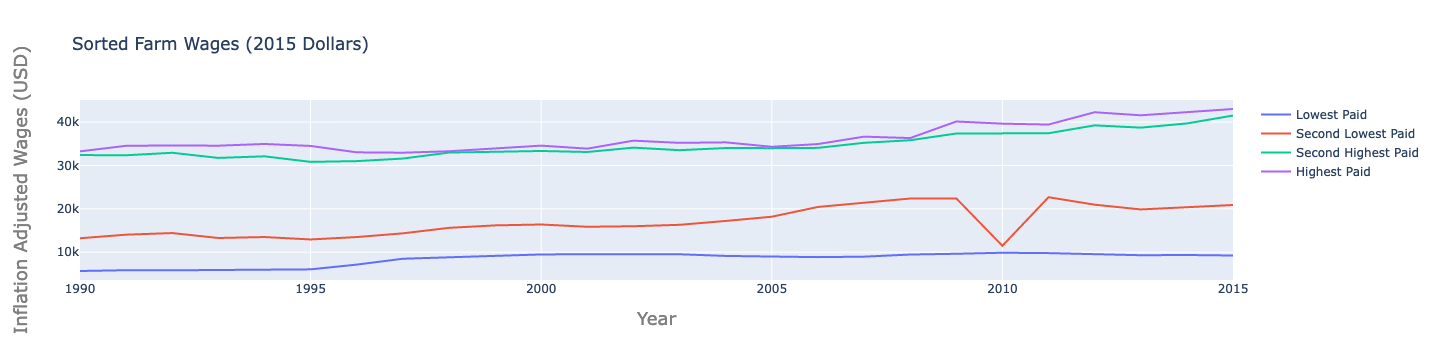

In [15]:
plot_df = crops_df[columns_to_see].groupby('year').nth(-1)

# Here is an example of how a plot which hover labels is made 
traces = []
# Here we put out the names of the traces we want to put on the graph
names = ["Lowest Paid", "Second Lowest Paid", "Second Highest Paid", "Highest Paid"]

# These numbers represent the lowest, second lowest, second highest and highest paid
# farmers from the plot_df with the grouping that we saw eariler. 

for j, i in enumerate([0,1,-2,-1]):
    plot_df = crops_df[columns_to_see].groupby('year').nth(i) 
    
    # Here we're adding a trace onto the end of our data frame
    # where index is the year 
    traces.append(go.Scatter(
      x=plot_df.index,
      y=plot_df.inflation_adj,
      text = plot_df.area_title,
      name = names[j]
    ))

# Here we're formatting axis labels
layout = go.Layout(
    title='Sorted Farm Wages (2015 Dollars)',
    xaxis=dict(
        title='Year',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Inflation Adjusted Wages (USD)',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=(traces), layout=layout)
    
iplot(fig)

En utilisant une parcelle comme celle-ci, il est facile de voir comment les salaires minimums et maximaux des agriculteurs ont changé aux États-Unis de 1990 à 2015. Il est également très simple de survoler le graphique avec une souris. terrain.

Des questions intéressantes qui pourraient être posées aux étudiants de ce complot pourraient entourer les circonstances dans lesquelles les agriculteurs de Porto Rico sont moins payés que les autres agriculteurs des États-Unis. Souvent beaucoup moins que l’état suivant le plus bas, à l’ordre de 5000 dollars par an. Cinq mille dollars par an représentent environ le tiers du salaire maximum des agriculteurs de Porto Rico.


Des tracés comme celui-ci peuvent rendre interactif et naturel que les élèves étudient les données. Peut-être y a-t-il une tendance qui les distingue - un problème social qui cause des écarts entre États ou d'importantes fluctuations salariales d'année en année. En effet, si vous trouvez ce cahier intéressant, nous pouvons créer quelque chose de similaire à utiliser dans votre classe. À condition que les données existent bien sûr.

 Vous pouvez demander à vos élèves d'interagir directement avec les données d'une manière que vous avez vue ici, ou nous pouvons masquer tout le codage en arrière-plan comme nous l'avons fait avec le widget et le graphique ci-dessus. À quel point l'interaction directe que vous voulez que vos élèves aient avec Python pour réussir la leçon / l'affectation dépend entièrement de vous.

# À emporter

Dans ce cahier, nous avons montré comment une application de sciences sociales existante peut être étendue dans votre classe de manière à démontrer la pensée informatique, la pensée critique et les compétences en recherche. Il a également montré comment utiliser des ensembles de données existants pour analyser plus en détail différents problèmes.

[![Callysto.ca License](https://github.com/callysto/curriculum-notebooks/blob/master/callysto-notebook-banner-bottom.jpg?raw=true)](https://github.com/callysto/curriculum-notebooks/blob/master/LICENSE.md)